In [1]:
import numpy as np
import matplotlib.pyplot as plt
from train import make_dataloader, train_model, probe_model
from model import ValueRNN
from tasks.eshel import Eshel
from tasks.trial import RewardAmountDistribution, RewardTimingDistribution
import torch

### Setting up the experiment

In [2]:
reward_time = [8]
reward_time_probs = [1.0]

# reward_sizes = [10]
# reward_size_probs = [1]
reward_sizes = [2, 4, 6, 8]
reward_size_probs = [0.25, 0.25, 0.25, 0.25]
# reward_sizes = [.1, .3, 1.2, 2.5, 5.0, 10.0, 20.0]
# reward_size_probs = [0.06612594, 0.09090909, 0.14847358, 0.15489467, 0.31159175, 0.1509519, 0.07705306]

#since we are using only 1 cue, therefore only one distribution is required
reward_sizes_dist = [RewardAmountDistribution(reward_sizes, reward_size_probs)] 
reward_timing_dist = [RewardTimingDistribution(reward_time, reward_time_probs)]

In [3]:
E = Eshel(rew_size_distributions= reward_sizes_dist,
          rew_time_distributions=reward_timing_dist,
          cue_shown=[True],
          cue_probs=[1.0],
          ntrials=10000,
          ntrials_per_episode=20,
          iti_min=5,
          iti_p=1/8,
          iti_max=0,
          jitter=0,
          iti_dist='geometric',
          t_padding=0)

## Creating the model

In [4]:
def create_nomenclature(alpha_plus_vector, alpha_minus_vector):
    alpha_plus_str = ''.join(str(alpha_plus_vector).split('.')).replace('[','').replace(']','').replace(' ','')
    alpha_minus_str = ''.join(str(alpha_minus_vector).split('.')).replace('[','').replace(']','').replace(' ','')
    model_name = '+[' + alpha_plus_str + ']-' + '[' + alpha_minus_str + ']'
    return model_name

In [5]:
hidden_size = 50 # number of hidden neurons
gamma = 0.93 # discount factor
model = ValueRNN(input_size=E.ncues + E.nrewards,
                 output_size=E.nrewards,
                 hidden_size=hidden_size, 
                 gamma=gamma,
                 recurrent_cell='GRU')     #choose the cell from RNN, LSTM, or GRU

print('model # parameters: {}'.format(model.n_parameters()))

model # parameters: 8151


In [6]:
# specifying the training parameters
epochs = 300
batch_size = 12
learning_rate = 0.003
alpha_plus = np.array([0.02, 0.04])     #learning rate for positive errors
alpha_minus = np.array([0.08, 0.06])    #learning rate for negative errors

dataloader = make_dataloader(E, batch_size=batch_size)

base_nomenclature = create_nomenclature(alpha_plus, alpha_minus)
model_name = base_nomenclature + f"_with_{epochs}epochs"

save_model = True
path_to_models = 'C:/Users/Asus/Desktop/distributional-td-learning_2/model_weights/reward_size=' + str(reward_sizes) + '/'

Epoch 0, loss: 0.0901
Epoch 25, loss: 0.0410
Epoch 50, loss: 0.0278
Epoch 75, loss: 0.0275
Epoch 100, loss: 0.0273
Epoch 125, loss: 0.0274
Epoch 150, loss: 0.0276
Epoch 175, loss: 0.0275
Epoch 200, loss: 0.0275
Epoch 225, loss: 0.0276
Epoch 250, loss: 0.0272
Epoch 275, loss: 0.0275
Done! Final loss: 0.027389487879800018
Done! Best loss: 0.02342500154653651


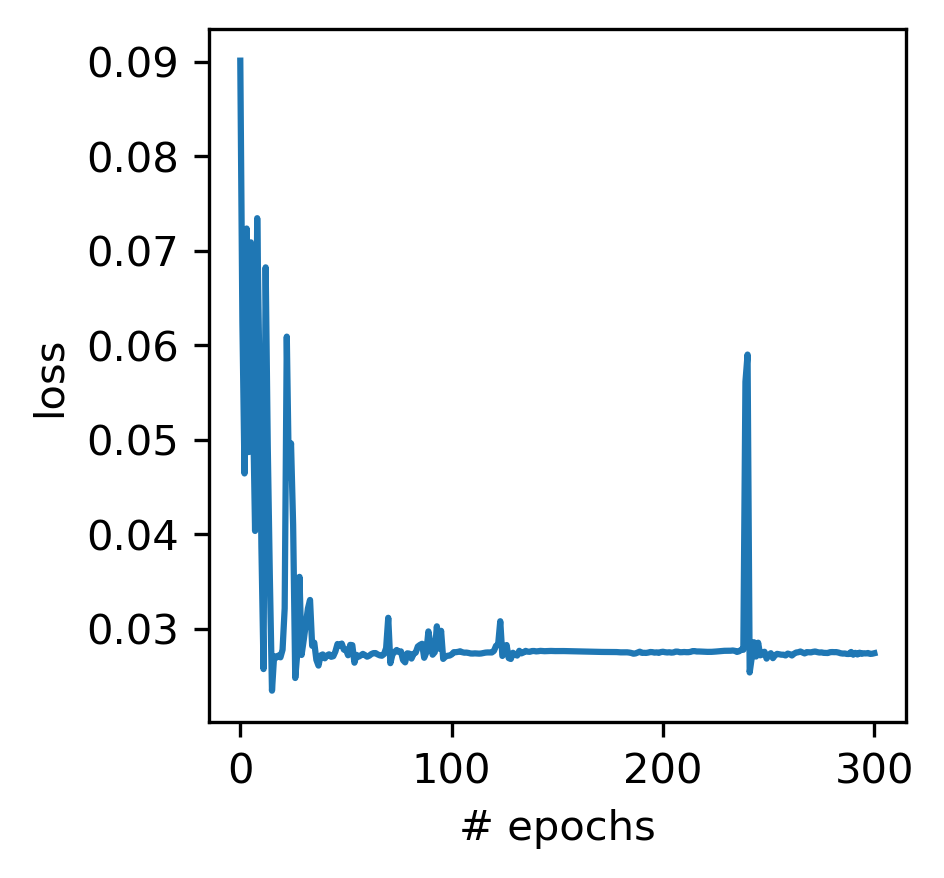

In [7]:
if save_model:
    scores, other_scores, weights = train_model(model, dataloader, 
                                                epochs=epochs, 
                                                optimizer='SGD', 
                                                lr=learning_rate,
                                                alpha_plus = alpha_plus,
                                                alpha_minus = alpha_minus,
                                                print_every=25,
                                                use_weights='final')

    plt.figure(figsize=(3,3), dpi=300), plt.plot(scores), plt.xlabel('# epochs'), plt.ylabel('loss')
    plt.savefig(path_to_models + model_name + "_loss", bbox_inches='tight')
    plt.show()
    torch.save(model.state_dict(), path_to_models + model_name + '_weights.pt')

else:
    model.load_state_dict(torch.load(path_to_models + model_name + '_weights.pt'))

## Probe and plot the model

In [8]:
responses = probe_model(model=model, 
                        alpha_plus=alpha_plus, 
                        alpha_minus=alpha_minus, 
                        dataloader=dataloader)[1:] # ignore first trial

In [9]:
#calculating the mean RPE values and the standard errors at the time of reward delivery
rpe_means = []
rpe_std_errors = []

for reward_size in reward_sizes:
    all_rpe = [trial.rpe[-1] for trial in responses if trial.reward_size == reward_size]
    rpe_mean = np.mean(all_rpe)
    rpe_std_error = np.std(all_rpe)/np.sqrt(len(all_rpe))
    rpe_means.append(rpe_mean)
    rpe_std_errors.append(rpe_std_error)

#saving standard errors of RPE into a text file to plot later
if save_model:
    np.savetxt(path_to_models + model_name + '_mean_rpes.txt', rpe_means)
    np.savetxt(path_to_models + model_name + '_rpe_std_errors.txt', rpe_std_errors)

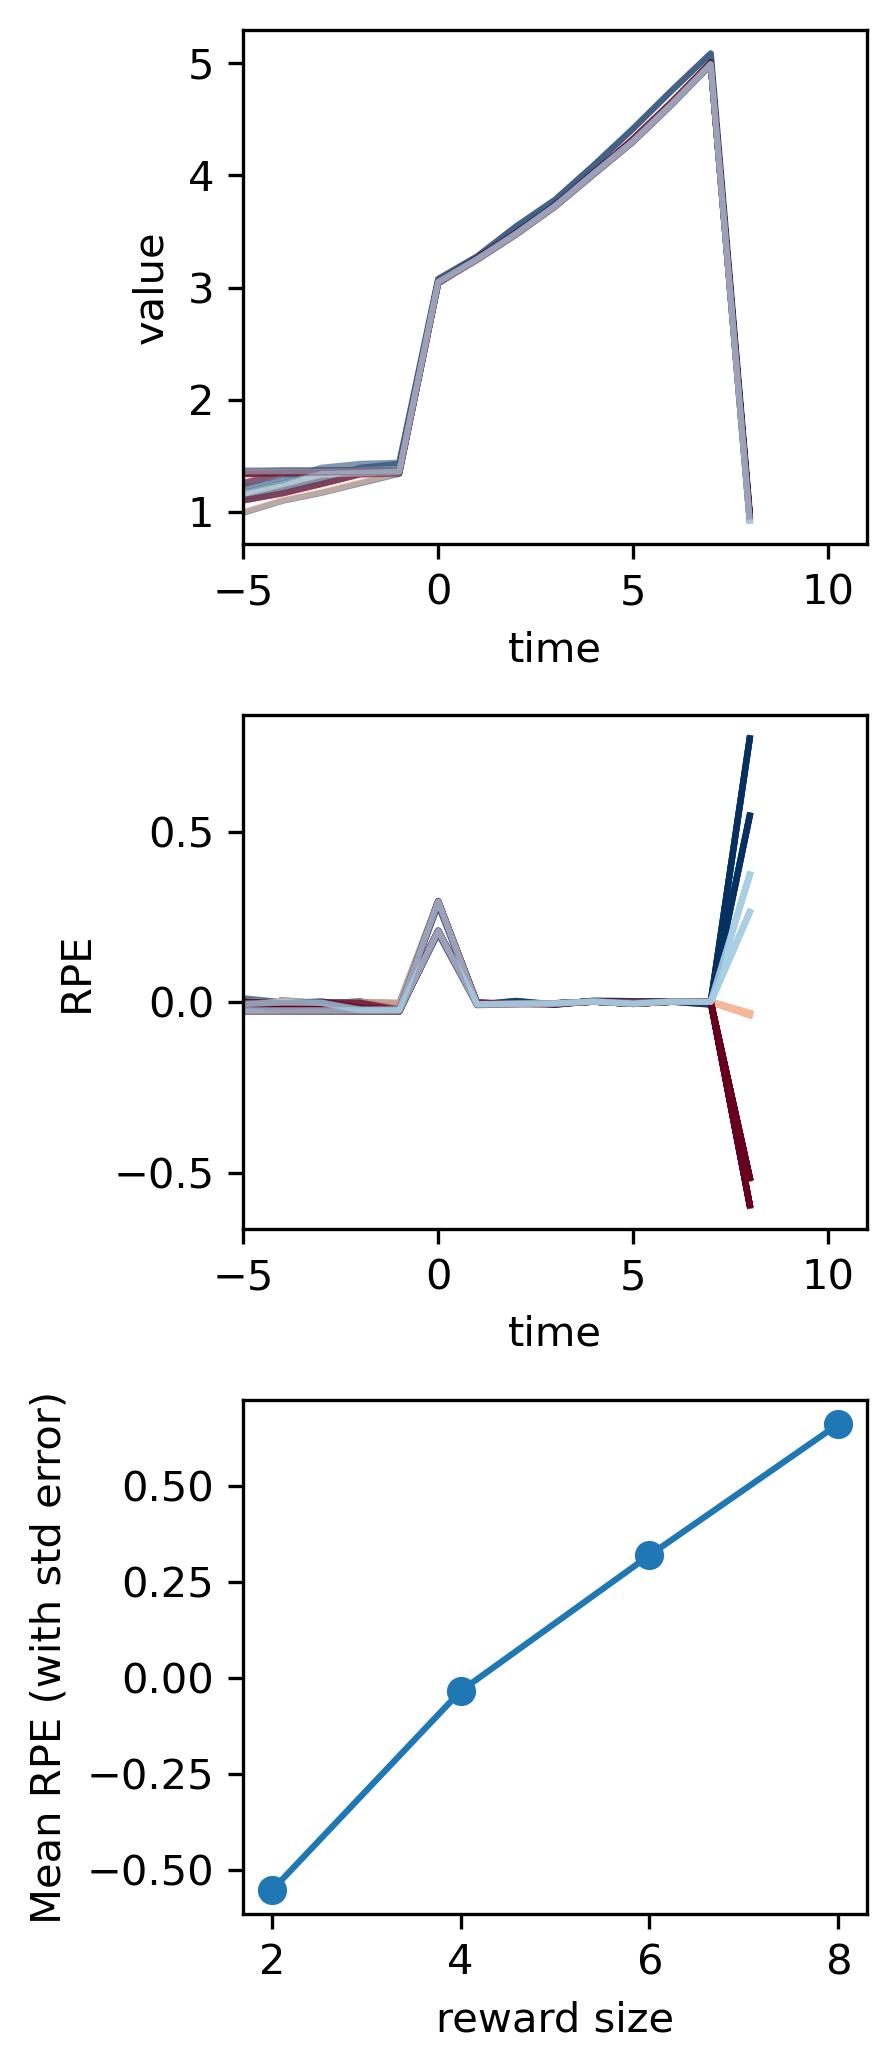

In [10]:
#plotting the results
rsizes = E.rew_size_distributions[0].rew_sizes
clrs = {rsizes[i]: plt.cm.RdBu(i/(len(rsizes)-1)) for i in np.arange(len(rsizes))}

plt.figure(figsize=(3,7), dpi=300)
for c,trial in enumerate(responses[:50]):
    xs = np.arange(len(trial)) - trial.iti
    
    plt.subplot(3,1,1)
    plt.plot(xs, trial.value, '-', color=clrs[trial.reward_size], alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.xlim([-5, 11])

    plt.subplot(3,1,2)
    plt.plot(xs[1:], trial.rpe, '-', color=clrs[trial.reward_size], alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('RPE')
    plt.xlim([-5, 11])

plt.subplot(3, 1, 3)
plt.errorbar(reward_sizes, rpe_means, yerr=rpe_std_errors, fmt='o-')
plt.xlabel('reward size')
plt.ylabel('Mean RPE (with std error)')

plt.tight_layout()
if save_model:    
    plt.savefig(path_to_models + model_name + "_results", bbox_inches='tight')
plt.show()

# print("Standard Errors in the RPE = ", rpe_std_errors)

## Plot Comparitive Result

In [15]:
file_path = "C:/Users/Asus/Desktop/distributional-td-learning_2/model_weights/reward_size=[2, 4, 6, 8]/"

std_errors_8_2 = np.loadtxt(file_path+"(+08)(-02)_with_600epochs_rpe_std_errors.txt")
mean_rpes_8_2 = np.loadtxt(file_path+"(+08)(-02)_with_600epochs_mean_rpes.txt")

std_errors_7_3 = np.loadtxt(file_path+"(+07)(-03)_with_425epochs_rpe_std_errors.txt")
mean_rpes_7_3 = np.loadtxt(file_path+"(+07)(-03)_with_425epochs_mean_rpes.txt")

std_errors_6_4 = np.loadtxt(file_path+"(+06)(-04)_with_250epochs_rpe_std_errors.txt")
mean_rpes_6_4 = np.loadtxt(file_path+"(+06)(-04)_with_250epochs_mean_rpes.txt")

std_errors_5_5 = np.loadtxt(file_path+"(+05)(-05)_with_300epochs_rpe_std_errors.txt")
mean_rpes_5_5 = np.loadtxt(file_path+"(+05)(-05)_with_300epochs_mean_rpes.txt")

std_errors_4_6 = np.loadtxt(file_path+"(+04)(-06)_with_250epochs_rpe_std_errors.txt")
mean_rpes_4_6 = np.loadtxt(file_path+"(+04)(-06)_with_250epochs_mean_rpes.txt")

std_errors_3_7 = np.loadtxt(file_path+"(+03)(-07)_with_250epochs_rpe_std_errors.txt")
mean_rpes_3_7 = np.loadtxt(file_path+"(+03)(-07)_with_250epochs_mean_rpes.txt")

std_errors_2_8 = np.loadtxt(file_path+"(+02)(-08)_with_300epochs_rpe_std_errors.txt")
mean_rpes_2_8 = np.loadtxt(file_path+"(+02)(-08)_with_300epochs_mean_rpes.txt")

std_errors_1_9 = np.loadtxt(file_path+"(+01)(-09)_with_250epochs_rpe_std_errors.txt")
mean_rpes_1_9 = np.loadtxt(file_path+"(+01)(-09)_with_250epochs_mean_rpes.txt")

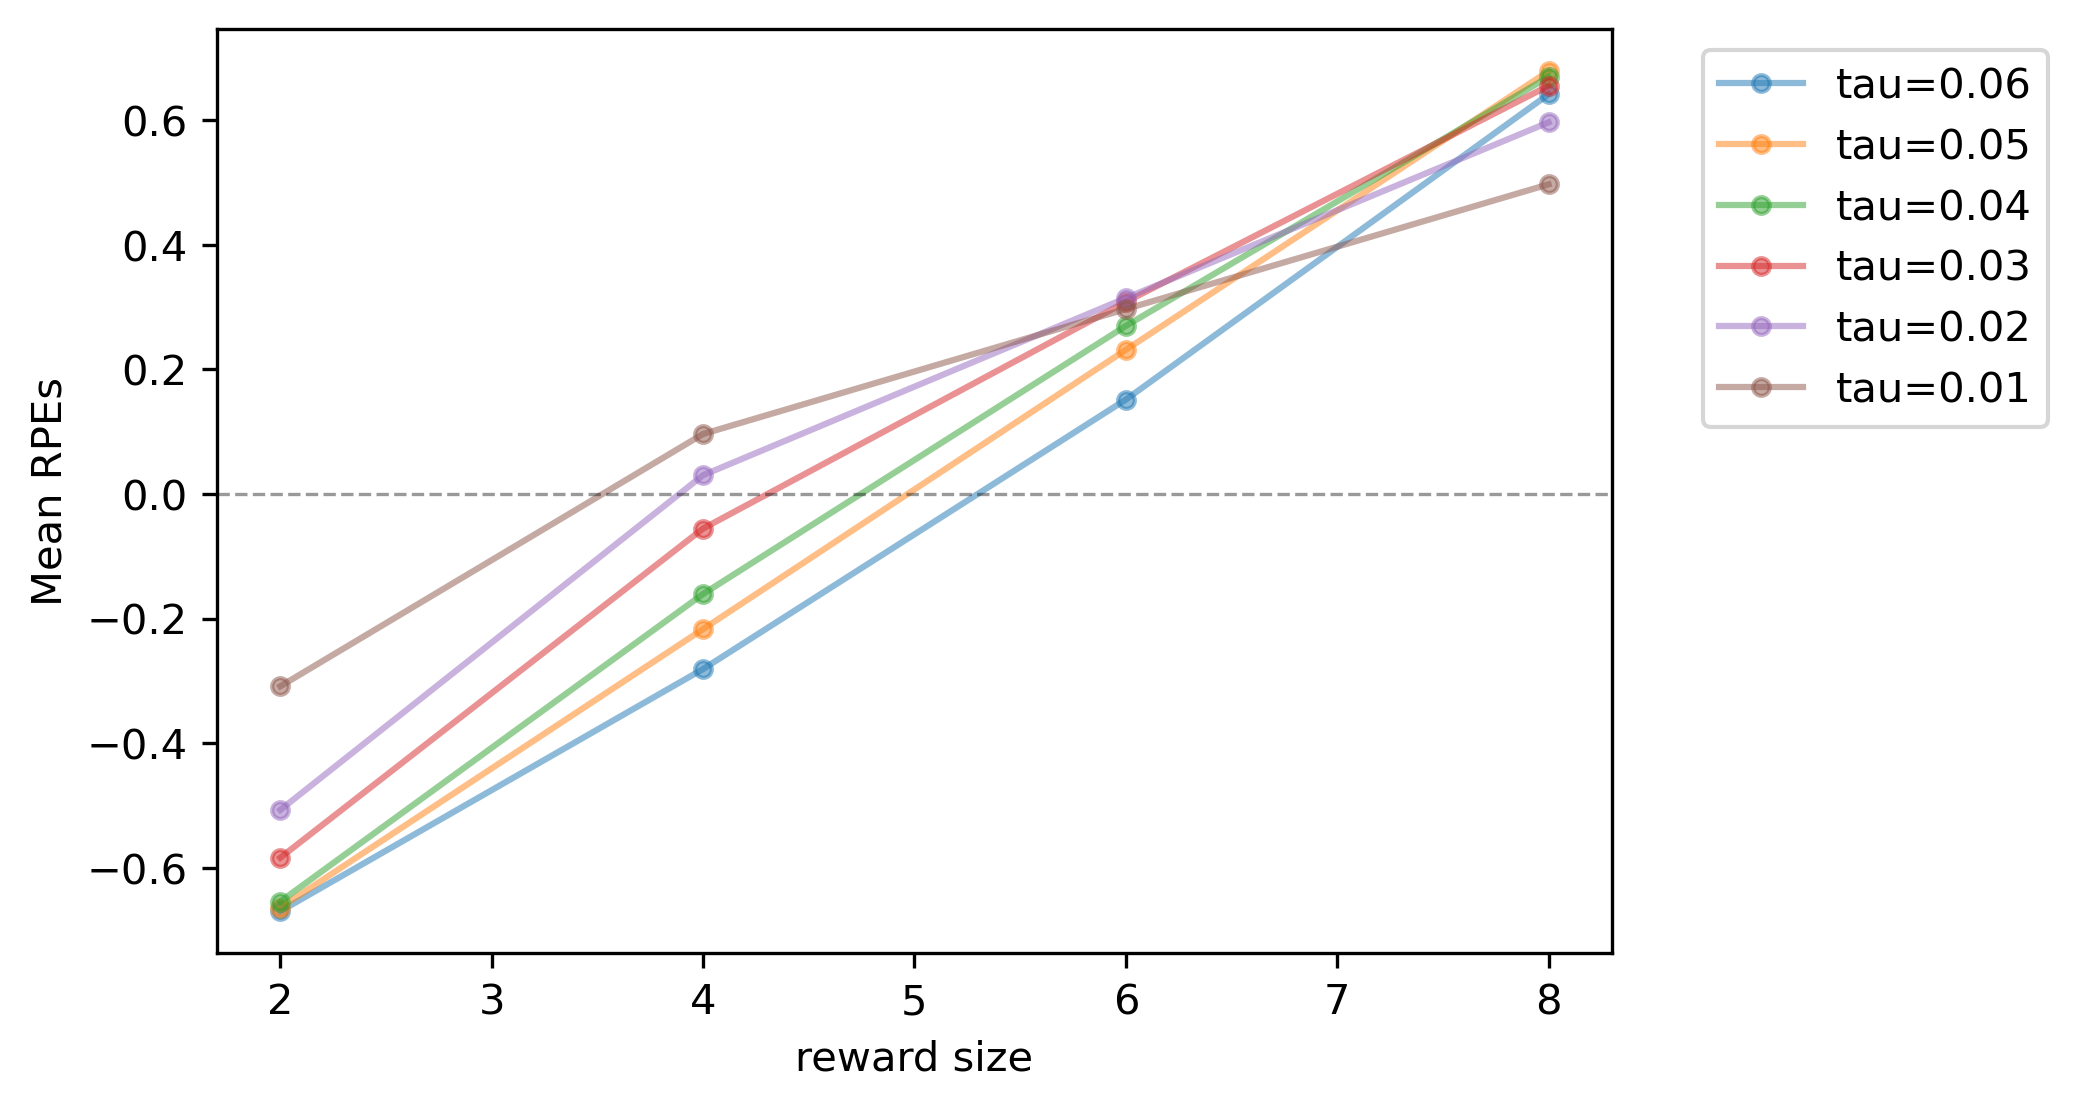

In [16]:
plt.figure(figsize=(6,4), dpi=300)
# plt.errorbar(reward_sizes, mean_rpes_8_2, yerr=std_errors_8_2, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.08', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_7_3, yerr=std_errors_7_3, fmt='o-', ecolor='r', ms=4, linewidth=1, elinewidth=1, label='tau=0.07', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_6_4, yerr=std_errors_6_4, fmt='o-', ecolor='y', ms=4, linewidth=1, elinewidth=1, label='tau=0.06', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_5_5, yerr=std_errors_5_5, fmt='o-', ecolor='g', ms=4, linewidth=1, elinewidth=1, label='tau=0.05', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_4_6, yerr=std_errors_4_6, fmt='o-', ecolor='b', ms=4, linewidth=1, elinewidth=1, label='tau=0.04', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_3_7, yerr=std_errors_3_7, fmt='o-', ecolor='k', ms=4, linewidth=1, elinewidth=1, label='tau=0.03', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_2_8, yerr=std_errors_2_8, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.02', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_1_9, yerr=std_errors_1_9, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.01', alpha=0.5)
# plt.ylabel('Mean RPEs (with standard errors)')

# plt.plot(reward_sizes, mean_rpes_8_2, 'o-', ms=4, label='tau=0.08', alpha=0.5)
# plt.plot(reward_sizes, mean_rpes_7_3, 'o-', ms=4, label='tau=0.07', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_6_4, 'o-', ms=4, label='tau=0.06', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_5_5, 'o-', ms=4, label='tau=0.05', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_4_6, 'o-', ms=4, label='tau=0.04', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_3_7, 'o-', ms=4, label='tau=0.03', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_2_8, 'o-', ms=4, label='tau=0.02', alpha=0.5)
plt.plot(reward_sizes, mean_rpes_1_9, 'o-', ms=4, label='tau=0.01', alpha=0.5)
plt.ylabel('Mean RPEs')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.4, linewidth=0.8)
# plt.axvline(x=5, color='k', linestyle='--', alpha=0.4, linewidth=0.8)
plt.xlabel('reward size')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

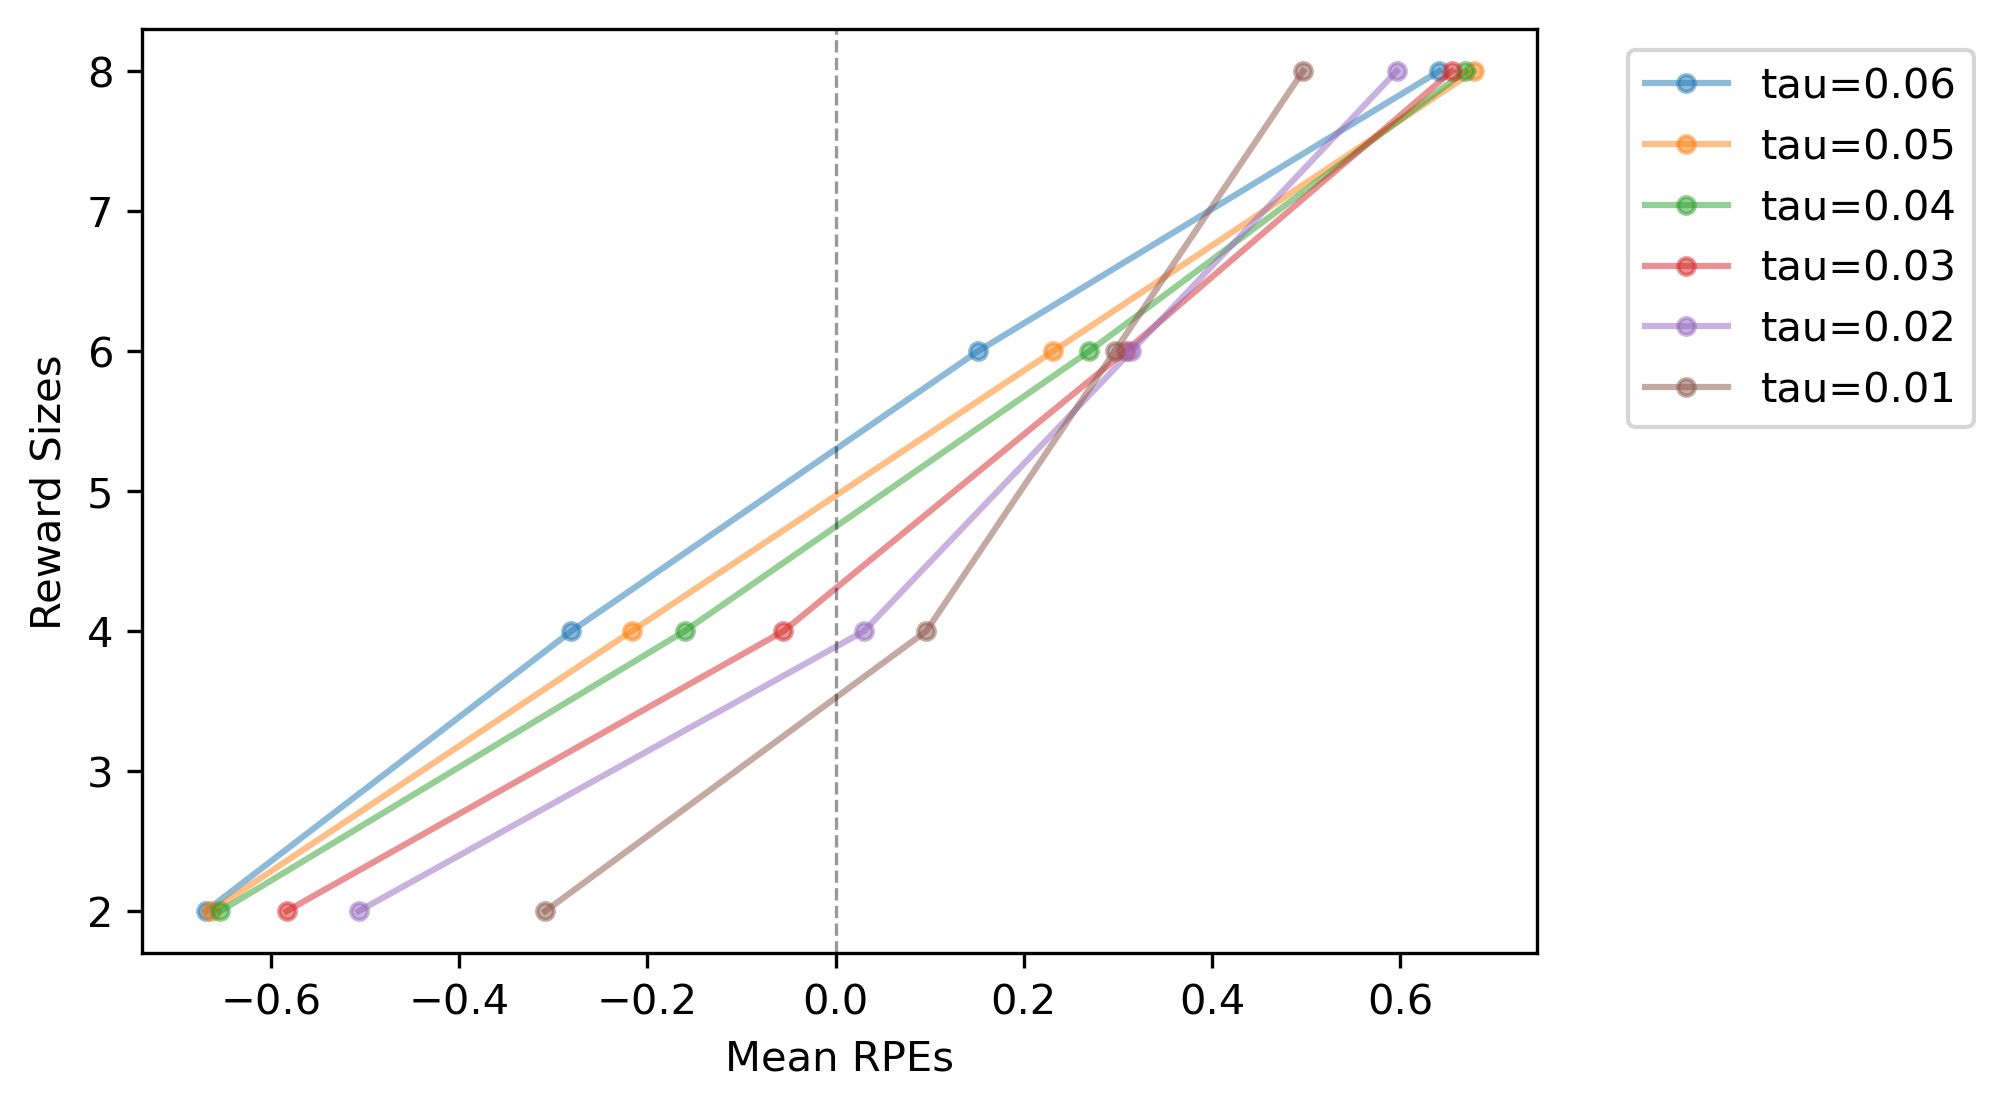

In [18]:
plt.figure(figsize=(6,4), dpi=300)
# plt.errorbar(reward_sizes, mean_rpes_8_2, yerr=std_errors_8_2, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.08', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_7_3, yerr=std_errors_7_3, fmt='o-', ecolor='r', ms=4, linewidth=1, elinewidth=1, label='tau=0.07', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_6_4, yerr=std_errors_6_4, fmt='o-', ecolor='y', ms=4, linewidth=1, elinewidth=1, label='tau=0.06', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_5_5, yerr=std_errors_5_5, fmt='o-', ecolor='g', ms=4, linewidth=1, elinewidth=1, label='tau=0.05', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_4_6, yerr=std_errors_4_6, fmt='o-', ecolor='b', ms=4, linewidth=1, elinewidth=1, label='tau=0.04', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_3_7, yerr=std_errors_3_7, fmt='o-', ecolor='k', ms=4, linewidth=1, elinewidth=1, label='tau=0.03', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_2_8, yerr=std_errors_2_8, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.02', alpha=0.5)
# plt.errorbar(reward_sizes, mean_rpes_1_9, yerr=std_errors_1_9, fmt='o-', ecolor='m', ms=4, linewidth=1, elinewidth=1, label='tau=0.01', alpha=0.5)
# plt.ylabel('Mean RPEs (with standard errors)')

# plt.plot(mean_rpes_8_2, reward_sizes, 'o-', ms=4, label='tau=0.08', alpha=0.5)
# plt.plot(mean_rpes_7_3, reward_sizes, 'o-', ms=4, label='tau=0.07', alpha=0.5)
plt.plot(mean_rpes_6_4, reward_sizes, 'o-', ms=4, label='tau=0.06', alpha=0.5)
plt.plot(mean_rpes_5_5, reward_sizes, 'o-', ms=4, label='tau=0.05', alpha=0.5)
plt.plot(mean_rpes_4_6, reward_sizes, 'o-', ms=4, label='tau=0.04', alpha=0.5)
plt.plot(mean_rpes_3_7, reward_sizes, 'o-', ms=4, label='tau=0.03', alpha=0.5)
plt.plot(mean_rpes_2_8, reward_sizes, 'o-', ms=4, label='tau=0.02', alpha=0.5)
plt.plot(mean_rpes_1_9, reward_sizes, 'o-', ms=4, label='tau=0.01', alpha=0.5)
plt.ylabel('Reward Sizes')

plt.axvline(x=0, color='k', linestyle='--', alpha=0.4, linewidth=0.8)
# plt.axhline(y=5, color='k', linestyle='--', alpha=0.4, linewidth=0.8)
plt.xlabel('Mean RPEs')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()